# UAV RID Spoofing Detection

---

*Data Augmentation File*

The goal of this project is to prove that Radio Frequency Fingerprints (RFF) can be used to detect spoofed RID messages. To define the scope of this project, we will only be aiming for a proof of concept. Keeping this in mind, this data augmentation file will do the following:

1. **Generate a UAV.** Each UAV will have a GPS, Flight Controller, Antenna, and Power system. The GPS is in charge of movement and location, the Flight Controller is in charge of RID message generation at 1 Hz, and the Power system affects RFF characteristics through hardware imperfections.

2. **Generate RID Message.** Standard ASTM F3411-19 compliant 25-byte message containing UAV identity, position, velocity, and timestamp.

3. **Generate RFF Fingerprint.** The UAV hardware creates a unique base RFF based on manufacturing imperfections. These include: (1) Carrier Frequency Offset (CFO), (2) Phase Noise, (3) I/Q Gain Imbalance, (4) I/Q Phase Imbalance, (5) DC Offset (I and Q channels), (6) Power Amplifier Compression.

4. **Transmit Signal.** Message modulation using BPSK (Binary Phase Shift Keying) and RFF application to I/Q samples.

5. **Channel Effects.** Apply realistic wireless propagation effects: path loss (distance-dependent attenuation), Rayleigh fading (multipath), and AWGN (thermal noise).

6. **Receive Transmission.** Capture raw I/Q samples containing the message, RFF, and channel effects. To remain in scope, we assume receiver RFF is negligible/calibrated out.

7. **Run Scenario.** Execute simulation scenarios and save data to CSV for ML processing. Each scenario uses different UAVs to ensure the ML model learns general hardware class characteristics rather than device-specific fingerprints, enabling generalization to unseen devices.

---

**Environment:**
- Open field scenario (no obstacles)
- Fixed ground-level receiver position
- Line-of-sight propagation

**UAV Behavior Types:**
- **Citizen** (Legitimate UAV with genuine RID)
- **UAV_Attack** (Malicious UAV in flight spoofing Citizen's identity using attacker hardware)
- **Ground_Attack** (Ground-based SDR spoofing Citizen's identity using SDR hardware)

**Attack Model:**
We simulate RID Identity Spoofing/Falsification attacks where the attacker creates fake RID messages claiming to be the Citizen UAV, but transmits using different hardware (HackRF SDR or cheap clone drone). The attacker's different hardware produces a different RFF, which our ML model learns to detect.

**Scenario Randomization:**
Each scenario features randomized:
- UAV starting positions
- Movement directions and speeds
- Hardware variations (within manufacturer specs)

This ensures the ML model generalizes to detect spoofing based on hardware class differences rather than memorizing specific device signatures.

In [2]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import time

# For DB generation at end
import h5py
import json

## Hardware Profile Generator

---

This section defines hardware characterisitcs for different manufacturers.
* DJI: (company=0): High-quality consumer drones (Citizen)
* HackRF (company=1): SDR hardware (Ground Attacker)
* Generic (company=2): Cheap clone drones (UAV Attacker)

Same company devices have a similar but not identical RFF, which allows the ML to learn company wide RFF rather than individual RFF which would require UAV enrollment and restrict generalization.

In [3]:
def gen_hardware_profile(device_id, company=0):
  """
  This fucntion generates hardware specs for a given device.

  Args:
    device_id (str): Unique Device ID ('DJI-001')
    comapny (str): Manufacturer of device (0:DJI, 1:HackRF, or 2:Generic)
  Returns:
    dict: Hardware profile with RFF ranges
  """
  seed = hash(device_id) % (2**32) # deterministic RFF
  rng = np.random.default_rng(seed)

  company_specs = {
      0: {
          'oscillator': 'TCXO',                # Temperature Compensated Crystal
          'freq_stability_ppm': (2, 10),       # ±2-10 parts per million
          'phase_noise_std': (0.01, 0.03),     # radians
          'iq_imbalance_db': (0.5, 2.0),       # dB
          'dc_offset_range': (0.005, 0.015),   # normalized
          'pa_compression_db': (-35, -30),     # dBm
      },
      1: {
          'oscillator': 'TCXO',
          'freq_stability_ppm': (0.5, 2),      # Better freq stability
          'phase_noise_std': (0.02, 0.04),     # Worse phase noise
          'iq_imbalance_db': (1.0, 3.0),       # Worse IQ balance
          'dc_offset_range': (0.01, 0.03),     # Higher DC offset
          'pa_compression_db': (-25, -20),     # Worse PA linearity
      },
      2: {
          'oscillator': 'Crystal',  # No temperature compensation!
          'freq_stability_ppm': (30, 50),      # Much worse
          'phase_noise_std': (0.03, 0.06),     # Much worse
          'iq_imbalance_db': (2.0, 4.0),       # Much worse
          'dc_offset_range': (0.02, 0.04),     # Much worse
          'pa_compression_db': (-28, -22),     # Worse PA
      }
  }

  # Default specs
  specs = company_specs.get(company, company_specs[0])

  # generate random RFF values within the given company's range:
  profile = {
      'device_id': device_id,
      'company': company,
      'oscillator_type': specs['oscillator'],
      'freq_stability_ppm': rng.uniform(*specs['freq_stability_ppm']),
      'phase_noise_std': rng.uniform(*specs['phase_noise_std']),
      'iq_imbalance_db': rng.uniform(*specs['iq_imbalance_db']),
      'dc_offset_range': rng.uniform(*specs['dc_offset_range']),
      'pa_compression_db': rng.uniform(*specs['pa_compression_db']),
  }

  return profile

## UAV Class Creation

---

This section creats a UAV with:

* Identity and manufacturer info
* Hardware profile and RFF characteristics
* GPS position (lat, lon, alt) and velocity (vx, vy, vz)
* Behavior type (Citizen, UAV_Attack, Ground_Attack)
* Spoofed ID for attackers

Supports simple linear movement simulation.

In [4]:
class UAV:
  def __init__(self, uav_id, company=0,
               lat=35.0, lon=-80, alt=100,
               vx=0.0, vy=0.0, vz=0.0):
    """
    This function creates a UAV

    Args:
      uav_id (str): Unique Device ID
      company (str): Manufacturer code (0:DJI, 1:HackRF, 2:Generic)
      lat, lon (float): Initial GPS position (degrees)
      alt (float): Initial altitude (meters)
      vx, vy, vz (float): Initial velocity (m/s)
    """
    self.id = uav_id
    self.company = company

    # Hardware Profile (determines RFF)
    self.hardware = gen_hardware_profile(uav_id, company)
    self.rff = gen_rff(self)

    # Map companny code to name
    self.company_name = {0: 'DJI', 1: 'HackRF', 2: 'Generic'}[company]

    # Position
    self.lat = lat
    self.lon = lon
    self.alt = alt

    # Velocity (m/s)
    self.vx = vx
    self.vy = vy
    self.vz = vz


    self.spoofed_id = None # For attackers, which ID are they spoofing
    self.behavior = 0 #0:Citizen, 1:UAV_Attack, 2:Ground_Attack

  def move(self, dt=1.0):
    """
    Update position based on velocity (linear movement)

    Args:
      dt (float): Time step (seconds)
    """

    # Velocity to lat/lon change,
    # 1 deg lat is 111 km, 1 deg lon is 111 km * cos (lat)
    dlat = (self.vy * dt) / 111000.0 # meters to degrees
    dlon = (self.vx * dt) / (111000.0 * np.cos(np.radians(self.lat)))
    dalt = self.vz * dt

    self.lat += dlat
    self.lon += dlon
    self.alt += dalt

  def get_position(self):
    """Return current position as dict"""
    return {'lat':self.lat, 'lon':self.lon, 'alt':self.alt}

  def get_velocity(self):
    """Return current velocity as dict"""
    return {'vx':self.vx, 'vy':self.vy, 'vz':self.vz}

  def __repr__(self):
    spoof_info = f" [SPOOFING: {self.spoofed_id}]" if self.spoofed_id else ""
    return (f"UAV({self.id}, {self.company_name}, "
            f"pos=({self.lat:.4f}°, {self.lon:.4f}°, {self.alt:.1f}m), "
            f"vel=({self.vx:.1f}, {self.vy:.1f}, {self.vz:.1f} m/s)"
            f"{spoof_info})")

## RID Message Generator

---

This section generates RID messages (ASTM F3411-19 compliant).

In [5]:
def gen_rid_message(uav):
  """
  This function genertes a 25-byte RID Message.

  Structure:
  [Header 1B][UAS_ID 8B][Lat 4B][Lon 4B][Alt 2B][Speed 2B][Heading 2B][Time 2B]

  Args:
    uav (UAV): UAV object
  Returns:
    bytes: 25-byte RID message
  """

  msg_type = 0x10 # Byte 0: Message Type

  # Bytes 1-8: UAS ID (8 char, ASCII),
  if uav.spoofed_id != None:
    uas_id = uav.spoofed_id # attacker uses Spoofed ID rather than their own
  else:
    uas_id = uav.id

  uas_id_bytes = uas_id.encode('ascii')[:8].ljust(8, b'\x00')

  # Bytes 9-16: Lat/Lon (degrees * 1e7, signed 32-bit)
  lat_encoded = int(uav.lat * 1e7)
  lon_encoded = int(uav.lon * 1e7)

  # Bytes 17-18: Alt (meters * 2, unsigned 16-bit)
  alt_encoded = int(uav.alt * 2)

  # Bytes 19-20: Speed (m/s * 4, unsigned 16-bit)
  speed = np.sqrt(uav.vx**2 + uav.vy**2)
  speed_encoded = int(speed * 4)

  # Bytes 21-22: Heading (degrees, unsigned 16-bit)
  if speed > 0.1:
    heading = int(np.degrees(np.arctan2(uav.vy, uav.vx))) % 360
  else:
    heading = 0

  # Bytes 23-24: Timestamp 9seconds since hour * 10, 0.1s precision)
  timestamp = int((time.time() % 3600) * 10)

  # Make bytearray {little-endian}
  message = bytearray(25)
  message[0] = msg_type
  message[1:9] = uas_id_bytes
  message[9:13] = lat_encoded.to_bytes(4, 'little', signed=True)
  message[13:17] = lon_encoded.to_bytes(4, 'little', signed=True)
  message[17:19] = alt_encoded.to_bytes(2, 'little', signed=False)
  message[19:21] = speed_encoded.to_bytes(2, 'little', signed=False)
  message[21:23] = heading.to_bytes(2, 'little', signed=False)
  message[23:25] = timestamp.to_bytes(2, 'little', signed=False)

  return bytes(message)

## RF Fingerprint Generator

---

This section generates a unique RFF based on hardware imperfections.

6 key features identified from literature:
1. Carrier Frequency Offset (CFO) - Crystal oscillator error
2. Phase Noise - Oscillator jitter
3. I/Q Gain Imbalance - Mixer imperfection
4. I/Q Phase Imbalance - Quadrature error
5. DC Offset (I and Q) - Self-mixing leakage
6. Power Amplifier Compression - PA saturation

In [6]:
def gen_rff(uav, t_c=25.0):
  """
  This function generates RF fingerprint based on hardware profile.

  Args:
    uav (UAV): UAV object with hardware profile
    t_c (float): Operating temp (celcius), affect oscillator
  Returns:
    dict: RFF parameters (6 features)
  """

  hw = uav.hardware
  rng = np.random.default_rng()
  #seed = hash(uav.id) % (2**32)
  #rng = np.random.default_rng(seed)

  # Carrier frequency (Wifi 2.4 GHz, channel 6)
  carrier_freq_hz = 2.437e9

  # ==================
  # RFF FEATURE 1: CFO
  # Caused by crystal oscillator tolerance.
  # Temp effect: +-2.5 ppm/c for TCX0, +- 50ppm/c for crystal
  if hw['oscillator_type'] == 'TCXO':
    temp_drift_ppm = (t_c - 25) * 2.5
  else:
    temp_drift_ppm = (t_c - 25) * 50

  cfo_ppm = rng.normal(0, hw['freq_stability_ppm']) + temp_drift_ppm
  cfo_hz = cfo_ppm * 1e-6 * carrier_freq_hz

  # ==========================
  # RFF FEATURE 2: PHASE NOISE
  # Caused by oscillator jitter, PLL noise
  phase_noise_std_rad = hw['phase_noise_std'] * rng.uniform(0.8, 1.2)

  # =================================
  # RFF FEATURE 3: I/Q GAIN IMBALANCE
  # Caused by imperfect quad mixer (1 and Q have diff gains)
  iq_gain_imbalance_db = hw['iq_imbalance_db'] * rng.uniform(0.8, 1.2)

  # ==================================
  # RFF FEATURE 4: I/Q PHASE IMBALANCE
  # Caused by mixer
  iq_phase_imbalance_deg = rng.uniform(1.0, 5.0)

  # ========================
  # RFF FEATURE 5: DC OFFSET
  # Caused by LO leakage
  dc_offset_i = rng.normal(0, hw['dc_offset_range'])
  dc_offset_q = rng.normal(0, hw['dc_offset_range'])

  # ==========================================
  # RFF FEATURE 6: POWER AMPLIFIER COMPRESSION
  # Caused by PA saturation at high power
  pa_compression_db = hw['pa_compression_db']

  rff = {
      'cfo_hz': cfo_hz,
      'phase_noise_std_rad': phase_noise_std_rad,
      'iq_gain_imbalance_db': iq_gain_imbalance_db,
      'iq_phase_imbalance_deg': iq_phase_imbalance_deg,
      'dc_offset_i': dc_offset_i,
      'dc_offset_q': dc_offset_q,
      'pa_compression_db': pa_compression_db
  }

  return rff

## I/Q Signal Transmission + Channel Effects

---

This section converts RID messages into RF signal with hardware fingerprint. We will use BPSK modulation and simulate realistic wireless channel effects between UAV and Ground Receiver.

Modulation Process:
1. Convert message bytes to bits
2. BPSK Modulation
3. Upsample to match sample rate
4. Apply carrier frequency (2.437) (Wifi 2.4 with Channel 6)
5. Apply RFF
6. Return I/Q samples

Channel effects Proccess:
1. Path loss
2. Rayleigh fading
3. Thermal noise (AWGN)

In [7]:
def transmit_signal(rid_message, uav, sample_rate_hz=20e6, duration_ms=1.0):
  """
  This function generates I/Q samples with RFF

  Args:
    rid_message (bytes): 25-byte RID message
    uav (UAV): UAV object
    sample_rate_hz (float): Sample rate (Hz)
    duration_ms (float): Duration of signal (ms)
  Returns:
    np.array: Complex I/Q sampels (dtype=complex128)
  """

  rff = uav.rff

  # Step1: bytes to bits
  bits = np.unpackbits(np.frombuffer(rid_message, dtype=np.uint8))

  # Step2: BPSK Modulatioin
  symbols = 2 * bits.astype(float) - 1

  # Step3: Upsample
  symbol_rate_hz = 1e6 # 1 Mbps
  samples_per_symbol = int(sample_rate_hz / symbol_rate_hz)
  symbols_upsampled = np.repeat(symbols, samples_per_symbol)

  symbol_bits = 25 * 8
  useful_samples = symbol_bits * samples_per_symbol

  # add padding or remove symbols to match desired duration
  n_samples = int(sample_rate_hz * duration_ms * 1e-3)
  if len(symbols_upsampled) < n_samples:
    symbols_upsampled = np.pad(symbols_upsampled, (0, n_samples
                                                   - len(symbols_upsampled)))
  else:
    symbols_upsampled = symbols_upsampled[:n_samples]

  t = np.arange(n_samples) / sample_rate_hz # time

  # Step4: RFF
  # 4a. Carrier + CFO
  cfo_phase = np.exp(2j * np.pi * rff['cfo_hz'] * t)
  #carrier_freq = 2.437e9 + rff['cfo_hz'] # CFO error
  #carrier = np.exp(2j * np.pi * carrier_freq * t)

  # 4b. Carrier + Phase noise
  phase_noise = np.cumsum(
      np.random.normal(0, rff['phase_noise_std_rad'], n_samples))
  signal = symbols_upsampled * cfo_phase * np.exp(1j * phase_noise)
  #carrier *= np.exp(1j * phase_noise)

  # 4c. Modulate
  #signal = symbols_upsampled * carrier
  signal = symbols_upsampled * cfo_phase

  # 4d. I/Q Imbalance (gain and phase)
  gain_i = 1 + rff['iq_gain_imbalance_db'] / 20
  gain_q = 1 - rff['iq_gain_imbalance_db'] / 20
  phase_error_rad = np.radians(rff['iq_phase_imbalance_deg'])

  # Apply
  signal_i = signal.real * gain_i
  signal_q = (signal.imag * np.cos(phase_error_rad)
              + signal.real * np.sin(phase_error_rad)) * gain_q
  signal = signal_i + 1j * signal_q

  # 4e. DC Offset
  signal += rff['dc_offset_i'] + 1j * rff['dc_offset_q']

  # 4f. PA
  # High-power samples get compressed
  signal_power_db = 10 * np.log10(np.abs(signal)**2 + 1e-12)
  mask = signal_power_db > rff['pa_compression_db']
  signal[mask] *= 0.9 # reduce amp of compressed samples

  # Step5: Normalize
  #signal /= (np.max(np.abs(signal)) + 1e-12)

  return signal


In [8]:
def apply_channel(tx_signal, tx_position, rx_position, snr_db=20):
  """
  This function applies wireless channel effects

  Args:
    tx_signal (np.array): Transmitted I/Q samples
    tx_position (dict): {'lat', 'lon', 'alt'} of transmitter
    rx_position (dict): {'lat', 'lon', 'alt'} of receiver
    snr_db (float): Signal to Noise Ratio (dB)
  Reutrns:
    tuple: (received_signal, distance_m)
  """

  # Step1: Cal 3D distance
  lat1, lon1, alt1 = tx_position['lat'], tx_position['lon'], tx_position['alt']
  lat2, lon2, alt2 = rx_position['lat'], rx_position['lon'], rx_position['alt']

  # Horizontal distance approx
  dlat_m = (lat2 - lat1) * 111000
  dlon_m = (lon2 - lon1) * 111000 * np.cos(np.radians((lat1 + lat2) / 2))
  dalt_m = alt2 - alt1

  distance_3d_m = np.sqrt(dlat_m**2 + dlon_m**2 + dalt_m**2)
  distance_3d_m = max(distance_3d_m, 1.0) # avoid division by 0

  # Step2: Free-space path loss
  # Formula: FSPL(dB) = 20*log10(d) + 20*log10(f) + 20*log10(4π/c)
  # Where: d = distance (m), f = frequency (Hz), c = speed of light
  freq_hz = 2.437e9 # Wifi 2.4 GHz

  fspl_db = (20 * np.log10(distance_3d_m)
             + 20 * np.log10(freq_hz)
             + 20 * np.log10(4 * np.pi / 3e8))

  path_loss_linear = 10**(-fspl_db / 20) # convert db to lin
  signal = tx_signal * path_loss_linear


  # Step3: Rayleigh fading (Multipath)
  # Channel coefficient: h ~ CN(0, 1) (complex normal distribution)
  K = 10  # Rician K-factor
  h = np.sqrt(K/(K+1)) + \
      np.sqrt(1/(K+1)) * (
          np.random.randn() + 1j*np.random.randn()
      ) / np.sqrt(2)
  #h = (np.random.randn() + 1j * np.random.randn()) / np.sqrt(2)
  signal = signal * h

  # Step4: Additive White Gaussian Noise (AWGN)
  signal_power = np.mean(np.abs(signal)**2)
  noise_power = signal_power / (10**(snr_db / 10))

  noise = np.sqrt(noise_power / 2) * (
      np.random.randn(len(signal)) + 1j * np.random.randn(len(signal))
  )

  received_signal = signal + noise

  return received_signal, distance_3d_m

## Visualization

### User Configuration

---

Define simulation parameters:
* ENV_CONFIG: Geographic boundaries (lat/lon)
* RECEIVER_CONFIG: Fixed ground receiver position
* UAV_CONFIG: Number of each UAV type (citizens, attackers)
* SIGNAL_CONFIG: SNR, duration, sample rate

In [9]:
# Environment boundaries (lat/lon in degrees)
ENV_CONFIG = {
    'lat_min': 35.000,
    'lat_max': 35.020,  # ~2.2 km span
    'lon_min': -80.020,
    'lon_max': -80.000,  # ~2.2 km span
    'name': 'Open Field'
}

# Receiver position (fixed, auto-centered in environment)
# Fixed at center of environment
RECEIVER_CONFIG = {
    'lat': (ENV_CONFIG['lat_min'] + ENV_CONFIG['lat_max']) / 2,
    'lon': (ENV_CONFIG['lon_min'] + ENV_CONFIG['lon_max']) / 2,
    'alt': 2.0  # 2 meters (ground level)
}

# UAV Configuration - How many of each type?
UAV_CONFIG = {
    'num_citizens': 3,      # Number of legitimate drones
    'num_uav_attackers': 2,  # Number of flying attackers
    'num_ground_attackers': 1  # Number of ground-based attackers
}

# Signal parameters
SIGNAL_CONFIG = {
    'snr_db': 20,           # Signal-to-noise ratio
    'duration_ms': 10.0,     # Signal duration
    'sample_rate_hz': 20e6  # Sampling rate
}

### Scenario Creation

---

Creates randomized scenarios with:
* Citizen UAVs (DJI, legitimate)
* UAV Attackers (Generic clones, airborne spoofing)
* Ground Attackers (HackRF SDR, stationary spoofing)

Each attacker randomly selects a Citizen victim to impersonate.

In [10]:
def create_scenario(env_config, receiver_config, uav_config):
    """
    This function creates a randomized scenario with the given configurations.

    Args:
        env_config (dict): Environment configuration
        receiver_config (dict): Receiver configuration
        uav_config (dict): UAV configuration
    Returns:
        list: List of UAV objects
    """
    uavs = []

    # Generate random position within boundaries
    def random_position():
        lat = np.random.uniform(env_config['lat_min'], env_config['lat_max'])
        lon = np.random.uniform(env_config['lon_min'], env_config['lon_max'])
        alt = np.random.uniform(80, 150)  # Random altitude 80-150m
        return lat, lon, alt

    # Generate random velocity
    def random_velocity():
        speed = np.random.uniform(5, 15)  # 5-15 m/s
        direction = np.random.uniform(0, 2*np.pi)  # Random direction
        vx = speed * np.cos(direction)
        vy = speed * np.sin(direction)
        return vx, vy, 0.0  # vz=0 (we are not changing alt for now)

    # Create CITIZEN UAVs
    for i in range(uav_config['num_citizens']):
        lat, lon, alt = random_position()
        vx, vy, vz = random_velocity()

        citizen = UAV(f"DJI-CITIZEN-{i+1:03d}", company=0,
                     lat=lat, lon=lon, alt=alt,
                     vx=vx, vy=vy, vz=vz)
        citizen.behavior = 0
        uavs.append(citizen)

    # Create UAV ATTACKERS (flying)
    for i in range(uav_config['num_uav_attackers']):
        lat, lon, alt = random_position()
        vx, vy, vz = random_velocity()

        attacker = UAV(f"GENERIC-PHANTOM-{i+1:03d}", company=2,
                      lat=lat, lon=lon, alt=alt,
                      vx=vx, vy=vy, vz=vz)

        # Spoof a random citizen (if citizens exist)
        if uavs:
            victim = np.random.choice([u for u in uavs if u.behavior == 0])
            attacker.spoofed_id = victim.id

        attacker.behavior = 1
        uavs.append(attacker)

    # Create GROUND ATTACKERS (stationary)
    for i in range(uav_config['num_ground_attackers']):
        lat, lon = np.random.uniform(env_config['lat_min'], env_config['lat_max']), \
                   np.random.uniform(env_config['lon_min'], env_config['lon_max'])

        attacker = UAV(f"HACKRF-GROUND-{i+1:03d}", company=1,
                      lat=lat, lon=lon, alt=2.0,  # Ground level
                      vx=0.0, vy=0.0, vz=0.0)  # Not moving (fixed position)

        # Spoof a random citizen
        if uavs:
            victim = np.random.choice([u for u in uavs if u.behavior == 0])
            attacker.spoofed_id = victim.id

        attacker.behavior = 2
        uavs.append(attacker)

    return uavs

### Scenario Signal Generation

In [11]:
def generate_scenario_signals(uavs, receiver_pos, signal_config):
    """This function generates signals for all UAVs in scenario"""
    results = []

    for uav in uavs:
        msg = gen_rid_message(uav)
        iq_tx = transmit_signal(msg, uav, duration_ms=signal_config['duration_ms'])
        iq_rx, distance = apply_channel(iq_tx, uav.get_position(), receiver_pos,
                                       snr_db=signal_config['snr_db'])
        rff = uav.rff

        results.append({
            'uav': uav,
            'iq_tx': iq_tx,
            'iq_rx': iq_rx,
            'rff': rff,
            'distance': distance
        })

    """
    phase = np.unwrap(np.angle(iq_rx))
    dphi = np.diff(phase)

    plt.plot(dphi[:2000])
    plt.title("Instantaneous Phase Increment")
    plt.grid()
    plt.show()
    """

    return results

### Visualize!

In [12]:
def visualize_scenario(uavs, receiver_pos, results, env_config, n_steps=20):
    """
    This function creats scenario with 6 subplots

    Args:
        uavs: List of UAV objects
        receiver_pos: Receiver position dict
        results: Signal generation results
        env_config: Environment configuration
        n_steps: Number of time steps to simulate for trajectories
    """

    # Color scheme
    colors = {
        0: '#497D15',  # CITIZEN: Blue
        1: '#82181A',  # UAV_ATTACK: Red
        2: '#DDD6FF',  # GROUND_ATTACK: Orange
    }

    behavior_names = {0: 'CITIZEN', 1: 'UAV_ATTACK', 2: 'GROUND_ATTACK'}

    # Create figure
    fig = plt.figure(figsize=(24, 14))
    gs = fig.add_gridspec(2, 1, hspace=0.25, height_ratios=[3, 1])

    # Subplots
    ax_map = fig.add_subplot(gs[0, :])        # Map
    ax_rx_amp = fig.add_subplot(gs[1, :])     # RX amplitude

    # =====================================
    # PLOT 1: MAP WITH TRAJECTORIES
    # =====================================
    ax_map.set_xlabel('Longitude (°)', fontsize=10)
    ax_map.set_ylabel('Latitude (°)', fontsize=10)
    ax_map.set_title('UAV Positions & Predicted Trajectories',
                     fontsize=12, fontweight='bold')
    ax_map.grid(True, alpha=0.3, linestyle='--')
    ax_map.set_aspect('equal')

    # Draw environment boundary
    env_width = env_config['lon_max'] - env_config['lon_min']
    env_height = env_config['lat_max'] - env_config['lat_min']
    boundary = Rectangle((env_config['lon_min'], env_config['lat_min']),
                         env_width, env_height,
                         fill=False, edgecolor='black',
                         linewidth=2, linestyle='--',
                         label='Environment Boundary')
    ax_map.add_patch(boundary)

    # Plot receiver
    ax_map.scatter(receiver_pos['lon'], receiver_pos['lat'],
                  marker='^', s=400, c='red', edgecolor='black', linewidth=2,
                  label='Receiver (Fixed)', zorder=10)

    # Plot UAVs and their trajectories
    for uav in uavs:
        color = colors[uav.behavior]
        behavior_name = behavior_names[uav.behavior]

        # Current position
        ax_map.scatter(uav.lon, uav.lat,
                      marker='o', s=150, c=color,
                       edgecolor='black', linewidth=1.5,
                      label=f"{behavior_name}: {uav.id}", zorder=5)

        # Predicted trajectory (dashed line)
        if uav.behavior != 2:  # No path for GA (stationary)
            trajectory_lons = [uav.lon]
            trajectory_lats = [uav.lat]

            # Simulate future positions
            temp_lat, temp_lon = uav.lat, uav.lon
            for step in range(n_steps):
                # Simple linear prediction
                dlat = (uav.vy * 1.0) / 111000.0
                dlon = (uav.vx * 1.0) / (111000.0 * np.cos(np.radians(temp_lat)))
                temp_lat += dlat
                temp_lon += dlon
                trajectory_lons.append(temp_lon)
                trajectory_lats.append(temp_lat)

            ax_map.plot(trajectory_lons, trajectory_lats,
                       linestyle='--', linewidth=2, alpha=0.6, color=color)

            # Arrow showing direction
            ax_map.annotate('', xy=(trajectory_lons[5], trajectory_lats[5]),
                          xytext=(trajectory_lons[0], trajectory_lats[0]),
                          arrowprops=dict(arrowstyle='->', lw=2, color=color, alpha=0.7))

            # If this UAV is spoofing another, show the falsified path
            if uav.spoofed_id:
                # Find the victim UAV being spoofed
                victim = next((u for u in uavs if u.id == uav.spoofed_id), None)
                if victim:
                    # Draw falsified trajectory (what attacker claims) in dotted style
                    falsified_lons = [victim.lon]
                    falsified_lats = [victim.lat]

                    temp_lat, temp_lon = victim.lat, victim.lon
                    for step in range(n_steps):
                        dlat = (victim.vy * 1.0) / 111000.0
                        dlon = (victim.vx * 1.0) / (111000.0 * np.cos(np.radians(temp_lat)))
                        temp_lat += dlat
                        temp_lon += dlon
                        falsified_lons.append(temp_lon)
                        falsified_lats.append(temp_lat)

                    # Plot falsified path in dotted line
                    ax_map.plot(falsified_lons, falsified_lats,
                                linestyle=':', linewidth=2.5, alpha=0.8, color=color,
                                label=f"{behavior_name} falsifying {victim.id}")

                    # Draw line connecting attacker's real position to falsified position
                    ax_map.plot([uav.lon, victim.lon], [uav.lat, victim.lat],
                                linestyle=':', linewidth=1, alpha=0.4, color='gray')

    ax_map.set_xlim(env_config['lon_min'] - 0.001, env_config['lon_max'] + 0.001)
    ax_map.set_ylim(env_config['lat_min'] - 0.001, env_config['lat_max'] + 0.001)
    ax_map.legend(loc='upper left', bbox_to_anchor=(1.02, 1),
                  fontsize=7, framealpha=0.9, borderaxespad=0)


    # =====================================
    # PLOT 2: RX AMPLITUDE
    # =====================================
    ax_rx_amp.set_xlabel('Sample Index', fontsize=9)
    ax_rx_amp.set_ylabel('Amplitude', fontsize=9)
    ax_rx_amp.set_title(
        'Received Signal Amplitude (After Channel - Distance Dependent)',
        fontsize=11, fontweight='bold')
    ax_rx_amp.grid(True, alpha=0.3)
    ax_rx_amp.set_xlim(0, 1500)

    for result in results:
        uav = result['uav']
        iq_rx = result['iq_rx']
        dist = result['distance']
        ax_rx_amp.plot(range(1500), np.abs(iq_rx[:1500]),
                      linewidth=1.5, alpha=0.7, color=colors[uav.behavior],
                      label=f"{uav.id} ({dist:.0f}m)")

    # Auto-scale
    max_rx = max(np.max(np.abs(r['iq_rx'][:1500])) for r in results)
    ax_rx_amp.set_ylim(0, max_rx * 1.2)
    ax_rx_amp.legend(loc='upper right', fontsize=8)

    # Overall title
    fig.suptitle(f'UAV RID Scenario Visualization - {len(uavs)} UAVs Total',
                fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Print summary
    print("\n" + "=" * 60)
    print("  SCENARIO SUMMARY")
    print("=" * 60)
    for result in results:
        uav = result['uav']
        behavior_name = behavior_names[uav.behavior]
        spoofing = f" → SPOOFING {uav.spoofed_id}" if uav.spoofed_id else ""
        print(f"{uav.id:25s} | {uav.company_name:8s} | {behavior_name:12s} | {result['distance']:6.1f}m{spoofing}")
    print("=" * 60)

/tmp/ipython-input-2584187555.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


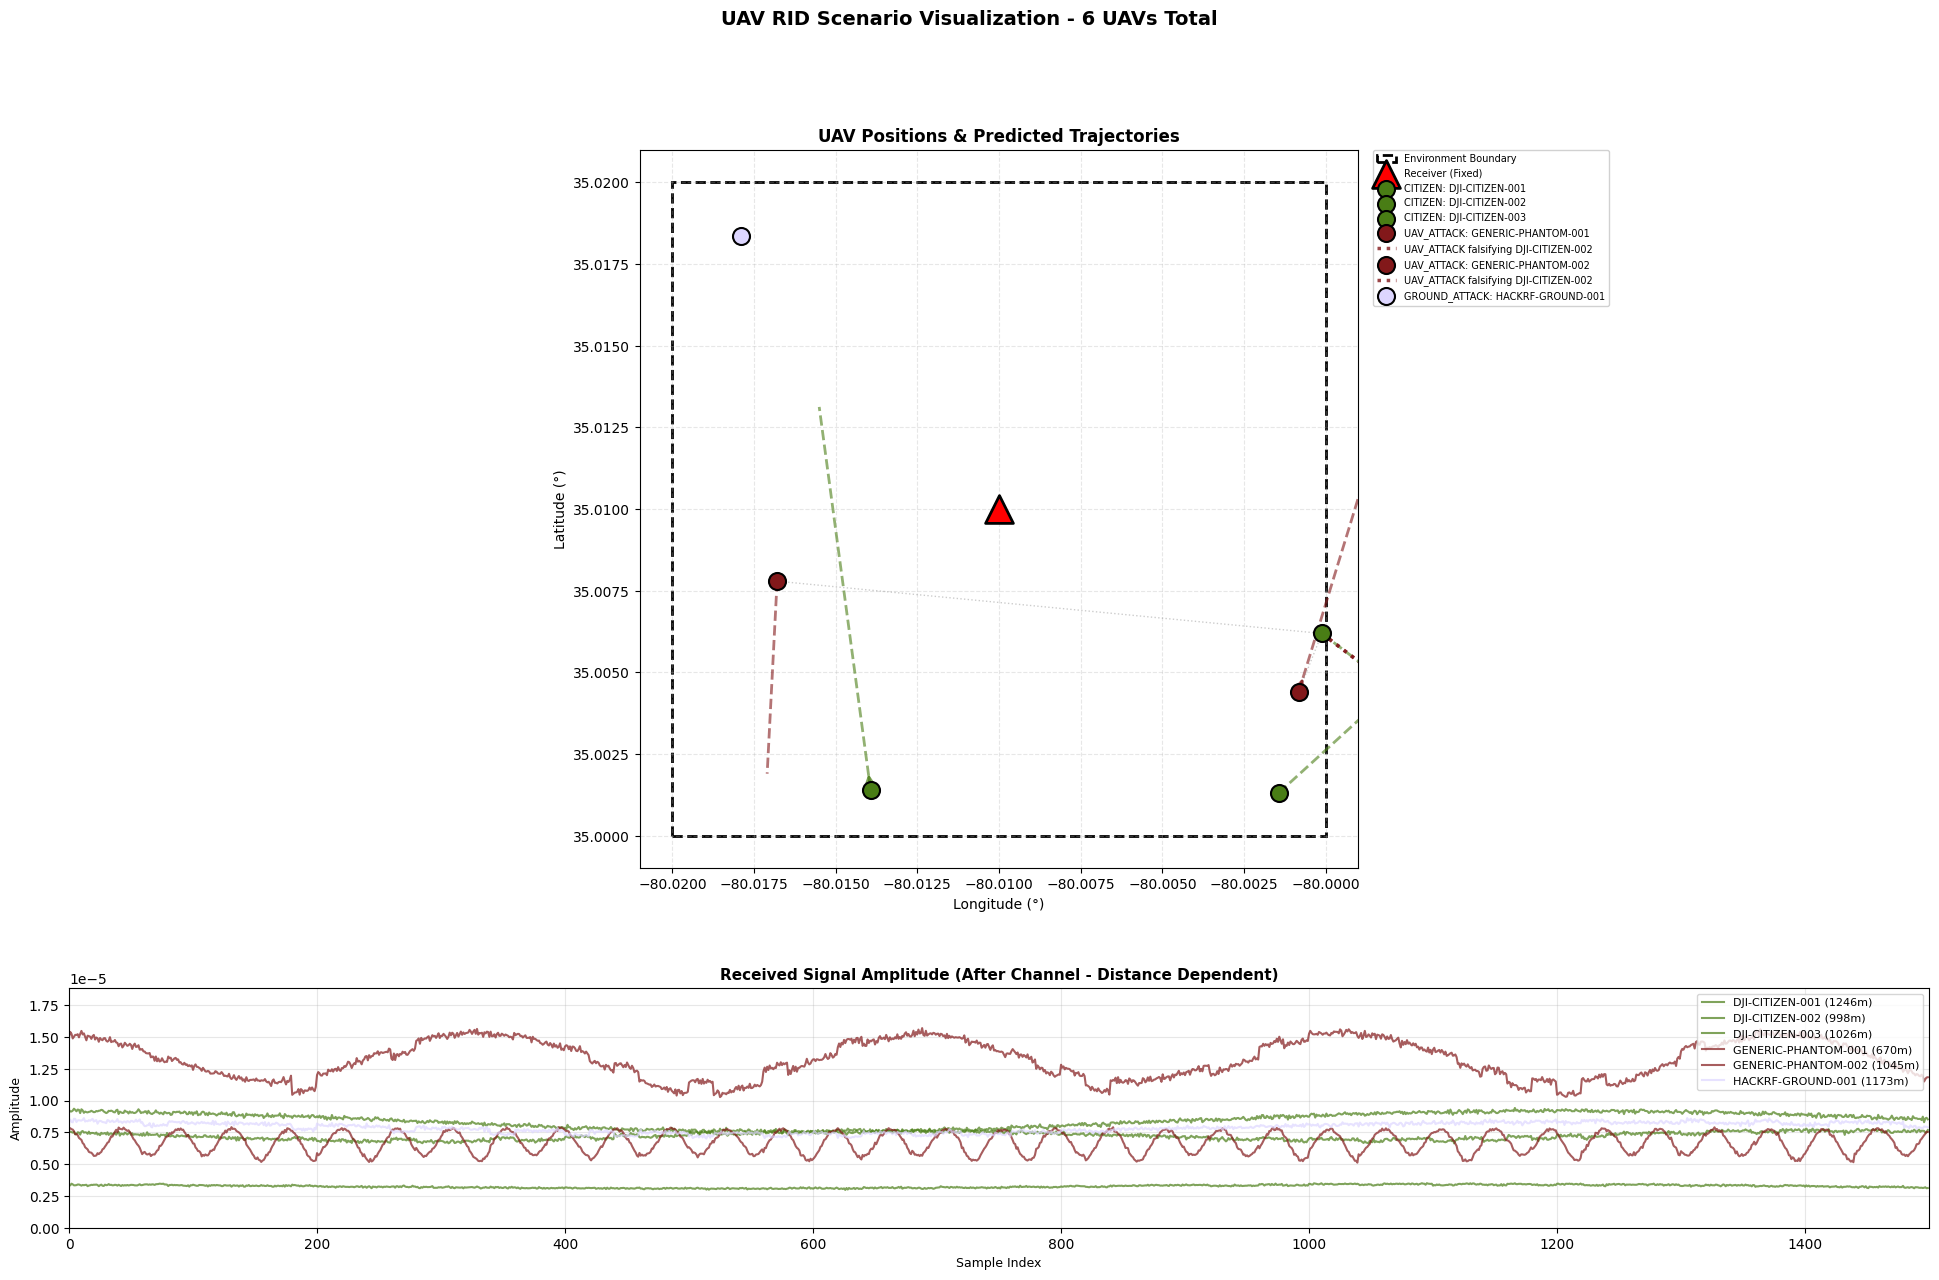


  SCENARIO SUMMARY
DJI-CITIZEN-001           | DJI      | CITIZEN      | 1245.6m
DJI-CITIZEN-002           | DJI      | CITIZEN      |  997.9m
DJI-CITIZEN-003           | DJI      | CITIZEN      | 1025.7m
GENERIC-PHANTOM-001       | Generic  | UAV_ATTACK   |  669.6m → SPOOFING DJI-CITIZEN-002
GENERIC-PHANTOM-002       | Generic  | UAV_ATTACK   | 1044.9m → SPOOFING DJI-CITIZEN-002
HACKRF-GROUND-001         | HackRF   | GROUND_ATTACK | 1173.3m → SPOOFING DJI-CITIZEN-002


In [27]:
# RUN!

# Create UAVs
uavs = create_scenario(ENV_CONFIG, RECEIVER_CONFIG, UAV_CONFIG)
# Generate signals
results = generate_scenario_signals(uavs, RECEIVER_CONFIG, SIGNAL_CONFIG)
# Visualize
visualize_scenario(uavs, RECEIVER_CONFIG, results, ENV_CONFIG, n_steps=100)

## Dataset Generation

---

This section creats the large dataset for ML traning with multiple geographic locations, varios drone behavior, and different environmental conditions (in terms of SNR and temperature).

The raw I/Q is saved as: I0, Q0, I1, Q1, ... , In, Qn, Label; where n=total number of I/Q samples collected.

Main variable to change here is the num_scenarios at the bottom of generate_dataset_csv(). 1 - 50 gets a good average within seconds, anything beyond will take longer.

In [19]:
def generate_dataset_csv(num_scenarios=100, output_file='uav_dataset.csv'):
    """
    This function generates a dataset by running multiple scenarios
    with random configurations. The results are saved to a CSV file.

    Args:
        num_scenarios (int): Number of scenarios to run
    """

    rows = []

    for scenario_idx in range(num_scenarios):
        # Randomize configurations
        uav_config_random = {
            'num_citizens': np.random.randint(1, 3),
            'num_uav_attackers': np.random.randint(0, 3),
            'num_ground_attackers': np.random.randint(0, 2)
        }

        base_lat = np.random.uniform(30, 45)
        base_lon = np.random.uniform(-120, -70)
        env_config_random = {
            'lat_min': base_lat,
            'lat_max': base_lat + 0.02,
            'lon_min': base_lon,
            'lon_max': base_lon + 0.02,
            'name': f'Location_{scenario_idx}'
        }

        receiver_pos = {
            'lat': (env_config_random['lat_min'] +
                    env_config_random['lat_max']) / 2,
            'lon': (env_config_random['lon_min'] +
                    env_config_random['lon_max']) / 2,
            'alt': 2.0
        }

        signal_config_random = {
            'snr_db': np.random.uniform(10, 30),
            'duration_ms': 10.0,
            'sample_rate_hz': 20e6
        }

        # Create scenario
        uavs = create_scenario(
            env_config_random, receiver_pos, uav_config_random)
        results = generate_scenario_signals(
            uavs, receiver_pos, signal_config_random)

        # Store data
        for result in results:
            uav = result['uav']
            iq_signal = result['iq_rx']
            useful_samples = 25 * 8 * int(20e6 / 1e6)  # 4000 samples
            iq_signal = result['iq_rx'][:useful_samples]

            iq_signal = iq_signal / (np.sqrt(np.mean(np.abs(iq_signal)**2)) + 1e-12)

            # Flatten I/Q: [I0, Q0, I1, Q1, I2, Q2, ...]
            row = []
            for sample in iq_signal:
                row.append(sample.real)
                row.append(sample.imag)
            row.append(uav.behavior)  # Label at end
            rows.append(row)


    # Create column names
    n_samples = len(rows[0]) - 1  # minus label
    columns = [f'IQ_{i}' for i in range(n_samples)] + ['Label']

    # Save to CSV
    df = pd.DataFrame(rows, columns=columns)
    df.to_csv(output_file, index=False)

    return df

# Generate dataset
df = generate_dataset_csv(num_scenarios=50)

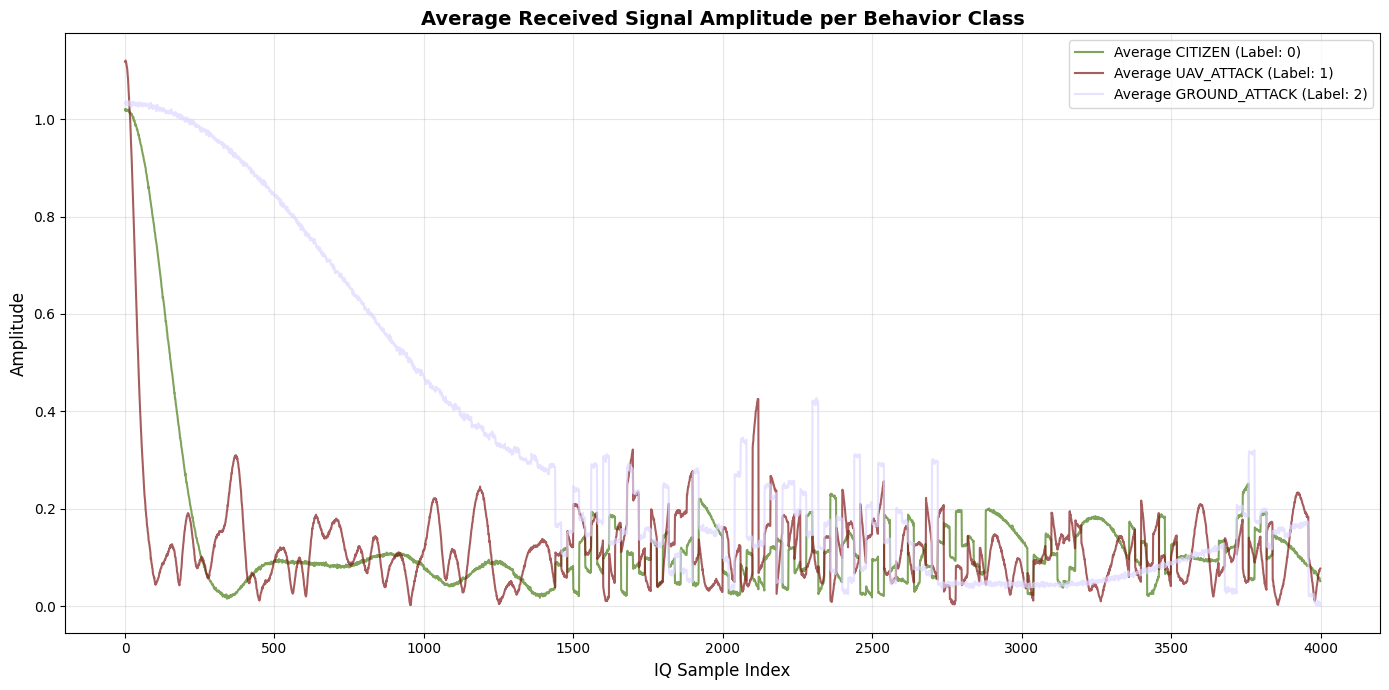

Plotted the average signal for each behavior type found in the DataFrame:
- Average CITIZEN (Label: 0)
- Average UAV_ATTACK (Label: 1)
- Average GROUND_ATTACK (Label: 2)


In [20]:
# Define the color scheme and behavior names for consistency with previous plots
colors = {
    0: '#497D15',  # CITIZEN
    1: '#82181A',  # UAV_ATTACK
    2: '#DDD6FF',  # GROUND_ATTACK
}
behavior_names = {0: 'CITIZEN', 1: 'UAV_ATTACK', 2: 'GROUND_ATTACK'}

def reconstruct_iq_signal(row_data):
    """
    Reconstructs the complex I/Q signal from a flattened DataFrame row.
    Assumes row_data is a pandas Series containing IQ_0, IQ_1, ..., IQ_N.
    """
    iq_values = row_data.values
    i_samples = iq_values[0::2] # Even indices are I samples
    q_samples = iq_values[1::2] # Odd indices are Q samples
    return i_samples + 1j * q_samples

# Create the plot
plt.figure(figsize=(14, 7))
plt.title('Average Received Signal Amplitude per Behavior Class', fontsize=14, fontweight='bold')
plt.xlabel('IQ Sample Index', fontsize=12)
plt.ylabel('Amplitude', fontsize=12)
plt.grid(True, alpha=0.3)

# Get unique labels
unique_labels = df['Label'].unique()
plotted_signals_info = []

for label in sorted(unique_labels):
    # Filter rows for the current label
    class_df = df[df['Label'] == label].iloc[:, :-1] # Exclude 'Label' column

    # Reconstruct all I/Q signals for this class
    all_iq_signals_in_class = [reconstruct_iq_signal(row) for index, row in class_df.iterrows()]

    # Calculate the average signal for the class
    if all_iq_signals_in_class:
        average_iq_signal = np.mean(all_iq_signals_in_class, axis=0)
    else:
        continue # Skip if no signals for this class

    # Plot the amplitude of the average signal
    behavior_label = behavior_names.get(label, f"Unknown ({label})")
    color = colors.get(label, 'gray') # Default to gray if label not in predefined colors
    plt.plot(np.abs(average_iq_signal), linewidth=1.5, alpha=0.7, color=color,
             label=f"Average {behavior_label} (Label: {label})")

    plotted_signals_info.append(f"Average {behavior_label} (Label: {label})")

plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()

print("Plotted the average signal for each behavior type found in the DataFrame:")
for info in plotted_signals_info:
    print(f"- {info}")

In [16]:
df.to_csv('uav_dataset.csv', index=False)